# Eulerian Tour

<b>Goal:</b> Implement a linear-time algorithm that computes an Eulerian tour in an Eulerian multidigraph, and compare its running time to the `networkx` implementation.

## Notes on a linear-time implementation

When implementing an Eulerian tour algorith, we usually do the following two steps:
1. Generating closed walks that partition the edges.
2. Merging the closed walks to a tour.
In both steps, one has to be a bit careful to achieve a real linear-time implementation.

### Step 1

Generating a single closed walk in an Eulerian graph is simple: One can just greedily traverse edges and continue walking from one vertex to another until the starting vertex is reached again. As the input graph is guaranteed to be Eulerian (i.e., indegrees equal outdegrees), we know that as long as we don't return to the start vertex (and thus close the walk), we will always have outgoing edges available to extend the walk.

The trickier part of step 1 is that we have to make sure that edges are not used twice. Checking which edge is still available at a vertex from scratch every time (for example by iterating through all outgoing edges and checking which ones are still unused) is dangerous to result in a non-linear algorithm. There are several options to avoid this; one is outlined in the proof of Theorem 3.21, another one can be using lists to store available out-edges at every vertex, and popping edges from the list whenever one is needed. Check out the small list example below. Note that a popping operation takes constant time.

In [186]:
mylist = [1, 2, 3, 4, 5]

print(f'Starting from list {mylist}.')

Starting from list [1, 2, 3, 4, 5].


In [187]:
element = mylist.pop()

print(f'We popped element {element} from the list, and the list now is {mylist}.')

We popped element 5 from the list, and the list now is [1, 2, 3, 4].


### Step 2

In the second step above, we have to merge the generated closed walks. For example, assume that the current tour is
    
    1 > 2 > 3 > 5 > 1
    
and we want to merge in the closed walk

    4 > 6 > 3 > 2 > 4.
   
One option to do so is to use the common vertex 3, and insert the closed walk (or, more precisely, a rotation of it) from there:

    1 > 2 > 3  >  2 > 4 > 6 > 3  >  5 > 1.

Again, simply cutting the current tour into two pieces at the correct point and inserting a closed walk in between is dangerous to result in a non-linear implementation: Both finding the right index to cut and creating the new concatenated list might take linear time in each step, and there might be linearly many steps overall.

Luckily, there are data structures that support constant time insertion; one such structure is a doubly-linked list. We provide an implementation of doubly-linked lists in what follows. Note that the list has very limited functionality, but it should be enough for our purposes. Feel free to add more functionality in case your later implementation profits from it. Also, check out the small example below!

In [188]:
class Node:
    def __init__(self, data):
        '''Initializes the node.'''
        self.data = data
        self.next = None
        self.prev = None


class DoublyLinkedList:
    def __init__(self):
        '''Initializes the doubly-linked list.'''
        self.head = None
        self.tail = None
        
    def append(self, data):
        '''Inserts a node with given data at the end of the doubly-linked list.'''
        new_node = Node(data)
         
        if self.head is None:
            self.head = self.tail = new_node
        else:
            self.tail.next = new_node
            new_node.prev = self.tail
            self.tail = new_node
    
    def insert(self, node, data):
        '''Inserts a node with given data after the given node.'''
        if node is None:
            self.append(data)
            return
        
        next_node = node.next
        
        new_node = Node(data)
        new_node.prev = node
        new_node.next = next_node
        
        node.next = new_node
        
        if next_node is None:
            self.tail = new_node
        else:
            next_node.prev = new_node
    
    def to_list(self):
        '''Returns a list representation of the doubly-linked list.'''
        l = []
        curr = self.head
        while curr is not None:
            l.append(curr.data)
            curr = curr.next
        return l

As we see from the implementation above, our doubly-linked list is a collection of `nodes`, where each node contains some data and a reference to the previous and the next node in the list. This makes it easy to insert new data somewhere in the middle (given that we know the node after which we want to insert).

In [189]:
dll = DoublyLinkedList()

In [190]:
dll.append(1)
dll.append(3)
dll.append(4)

In [191]:
print(f'Currently in our DLL: {dll.to_list()}.')

Currently in our DLL: [1, 3, 4].


In [192]:
head = dll.head
dll.insert(head, 2)
print(f'Inserted the missing 2, DLL now is {dll.to_list()}.')

Inserted the missing 2, DLL now is [1, 2, 3, 4].


In [193]:
node_2 = head.next
dll.insert(node_2, 2.5)

node_3 = dll.tail.prev
dll.insert(node_3, 3.5)

l = dll.to_list()
print(f'Final list is {l}.')

Final list is [1, 2, 2.5, 3, 3.5, 4].


### Final note

Note that it is not strictly necessary to separate steps 1 and 2 above. If, for example, we always generate a new closed walk that intersects the current tour, we can also right away insert it into the tour. Even more generally, the edges of a closed walk can also be inserted into a tour already during creation of the tour.

---

## Implementation

The interface for your implementation of an Eulerian tour algorithm is given below.

In [194]:
import networkx as nx

import random

In [224]:
def one_iter(unusedOutgoingEdges, path, pathPos, currentNode):
    travelEdge = unusedOutgoingEdges[currentNode].pop()
    if (len(unusedOutgoingEdges[currentNode]) == 0):
        del unusedOutgoingEdges[currentNode]
    path.insert(pathPos, travelEdge)
    return travelEdge[1]

def eulerian_tour(G):
    '''Computes an Eulerian tour.
    
    Args:
        G: An Eulerian netwrokx multidigraph.
        
    Returns:
        A list of arcs in the format (u, v, k) in an Eulerian tour in G.
    '''


    # construct outgoing edge lists
    unusedOutgoingEdges = {n: [] for n in G.nodes}
    for e in G.edges:
        unusedOutgoingEdges[e[0]].append(e)

    path = DoublyLinkedList()

    startingNode = next(iter(unusedOutgoingEdges))
    currentNode = one_iter(unusedOutgoingEdges, path, None, startingNode)
    currentPathNode = path.head
    while(len(unusedOutgoingEdges) > 0):
        while currentNode != startingNode:
            currentNode = one_iter(unusedOutgoingEdges, path, currentPathNode, currentNode)
            currentPathNode = currentPathNode.next
        if len(unusedOutgoingEdges) > 0:
            n = path.head.next # cannot use head since we cannot insert a new head..
            specialCase = False
            if n is None :
                specialCase = True
                n = path.head
            while True:
                if n.data[0] in unusedOutgoingEdges:
                    startingNode = n.data[0]
                    currentPathNode = n.prev if not specialCase else n
                    currentNode = one_iter(unusedOutgoingEdges, path, currentPathNode, startingNode)
                    currentPathNode = currentPathNode.next
                    break
                n = n.next

    return path.to_list()

---

## Testing

You can use the function below on the given examples to test your implementation. Note that the third example cell generates random graphs, so you can test on new instances over and over.

In [235]:
def test_eulerian_tour(G, edge_list):
    '''Tests if a given list of edges is an eulerian tour in a given graph.
    
    Args:
        G: A networkx multidigraph.
        edge_list: A list of edges in the format (u, v, k).
        
    Returns:
        True if edge_list is an Eulerian tour in G and False otherwise.
    '''
    
    assert nx.is_eulerian(G), "Graph is not Eulerian."
    
    used = {e: False for e in G.edges}
    
    for i in range(len(edge_list)):
        prev = edge_list[i - 1]
        edge = edge_list[i]
        
        if prev[1] != edge[0]:
            # Continuing from a different vertex
            return False

        if used[edge]:
            # Traversing edge for the second time
            return False
        used[edge] = True
        
    return False not in used.values()

In [236]:
# Instance 1
G1 = nx.MultiDiGraph()

G1.add_edges_from([
    (1, 3),
    (2, 1),
    (2, 3),
    (3, 5),
    (3, 7),
    (4, 2),
    (4, 6),
    (5, 4),
    (5, 7),
    (6, 5),
    (7, 2),
    (7, 4)
])

tour1 = eulerian_tour(G1)
print(f"Tour: {tour1}")
print(f"The computed tour {'is' if test_eulerian_tour(G1, tour1) else 'is not'} an Eulerian tour.")

Tour: [(1, 3, 0), (3, 7, 0), (7, 4, 0), (4, 6, 0), (6, 5, 0), (5, 7, 0), (7, 2, 0), (2, 3, 0), (3, 5, 0), (5, 4, 0), (4, 2, 0), (2, 1, 0)]
The computed tour is an Eulerian tour.


In [237]:
# Instance 2
# (from Figure 3.4 in the script)
G2 = nx.MultiDiGraph()

G2.add_edges_from([
    (1, 4),
    (1, 4),
    (2, 3),
    (2, 3),
    (3, 6),
    (3, 6),
    (4, 2),
    (4, 9),
    (5, 2),
    (6, 5),
    (6, 7),
    (7, 8),
    (8, 9),
    (9, 1),
    (9, 1),
])

tour2 = eulerian_tour(G2)
print(f"Tour: {tour2}")
print(f"The computed tour {'is' if test_eulerian_tour(G2, tour2) else 'is not'} an Eulerian tour.")

Tour: [(1, 4, 1), (4, 2, 0), (2, 3, 0), (3, 6, 0), (6, 5, 0), (5, 2, 0), (2, 3, 1), (3, 6, 1), (6, 7, 0), (7, 8, 0), (8, 9, 0), (9, 1, 0), (1, 4, 0), (4, 9, 0), (9, 1, 1)]
The computed tour is an Eulerian tour.


In [241]:
# Random instances
import random

def random_eulerian_graph(m):
    '''Generates a random Eulerian multidigraph on n = 10 sqrt(m) vertices and m edges.
    
    Args:
        m: Number of edges that the output graph should contain.
        
    Returns:
        Random Eulerian multidigraph on n = 10 sqrt(m) vertices and m edges.
    '''
    G = nx.MultiDiGraph()
    n = int(10*m**0.5)
    
    v = 0
    for i in range(m - 1):
        u = random.randint(0, n)
        G.add_edge(v, u)
        v = u
    G.add_edge(v, 0)
    
    return G

# Change the size f you like!
m = 10000
G_rand = random_eulerian_graph(m)
tour_rand = eulerian_tour(G_rand)
print(f"The computed tour {'is' if test_eulerian_tour(G_rand, tour_rand) else 'is not'} an Eulerian tour.")

The computed tour is an Eulerian tour.


In [244]:
# May own instance with loops, derived from Instance 2

G2 = nx.MultiDiGraph()

G2.add_edges_from([
    (1, 1),
    (1, 1),
    (1, 4),
    (1, 4),
    (1, 1),
    (2, 3),
    (2, 3),
    (3, 6),
    (3, 6),
    (4, 2),
    (4, 9),
    (5, 2),
    (6, 5),
    (6, 7),
    (7, 8),
    (8, 9),
    (9, 1),
    (9, 1),
])

tour2 = eulerian_tour(G2)
print(f"Tour: {tour2}")
print(f"The computed tour {'is' if test_eulerian_tour(G2, tour2) else 'is not'} an Eulerian tour.")

Tour: [(1, 4, 1), (4, 2, 0), (2, 3, 0), (3, 6, 0), (6, 5, 0), (5, 2, 0), (2, 3, 1), (3, 6, 1), (6, 7, 0), (7, 8, 0), (8, 9, 0), (9, 1, 0), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 4, 0), (4, 9, 0), (9, 1, 1)]
The computed tour is an Eulerian tour.


---

## Running time measurements and comparison to the `networkx` implementation 

In the cell below, we provide a framework for measuring CPU time needed for execution of your algorithm on graphs of different size, and for comparing it to the running time of the corresponding `networkx` method.

- We generate random graphs of different sizes and run the algorithms on them. To avoid outliers, we generate `num_reps` many graphs of the same size and report the median running time only.
- The `multiprocessing` library is used to exploit the available computing power of your machine (i.e., use all available cores). Check the documentation of the library if you're interested in more details; it is a very useful tool for such computations.
- Depending on your hardware, you might be able to run smaller or larger instances in reasonable time. Try playing around with the `max_size` parameter (or directly with the `m_vals`, which ist the list of graph sizes that are considered for the measurements).
- The `compare_performance` method below is implemented such that the performance of two algorithms can be compared. If you came up with different implementations, you can also thest them against each other! By default, the first algorithm specified is compared to the `networkx` implementation.

Have fun playing with the parameters and your implementations! You should be well able to beat the implementation by networkx.

In [231]:
import multiprocessing as mp
import statistics
import time
import matplotlib.pyplot as plt

# testing parameters
num_reps = 15
max_size = 250000
m_vals = range(100, max_size+101, max_size//10)


def single_graph_timer(function1, function2, m):
    '''Times the execution of function1 and function2 on a random eulerian graph with m edges.
    
    Args:
        function1: First function to time.
        function2: Second function to time.
        m: Number of edges of the graph that the functions should be timed on.
        
    Returns:
        CPU times (in seconds) needed for calls to function1 and function2 (on the same graph on m edges).
    '''
    # generate graph
    graph = random_eulerian_graph(m)
    
    # Measure performance
    start1 = time.process_time()
    tour1 = function1(graph)
    end1 = time.process_time()
    start2 = time.process_time()
    tour2 = function2(graph)
    end2 = time.process_time()

    # Teturn time taken for function call.
    return (end1 - start1, end2 - start2)



def networkx_eulerian_circuit(G):
    # Note: It is important that we transform the result to a list here.
    # nx.eulerian_circuit only returns an iterator that is evaluated in a lazy way!
    return list(nx.eulerian_circuit(G))



def compare_performance(function1, function1_name, function2=networkx_eulerian_circuit, function2_name='networkx_eulerian_circuit'):
    
    fun1_medians = []
    fun2_medians = []
    
    with mp.Pool() as pool:
        for m in m_vals:   
            print(f"Computing tours in graphs with {m} edges.")
            times = pool.starmap(single_graph_timer, [(function1, function2, m)] * num_reps)
            fun1_medians.append(statistics.median([t[0] for t in times]))
            fun2_medians.append(statistics.median([t[1] for t in times]))
            
    # Plot results
    plt.title('Performance of algorithms for computing an Eulerian tour')
    plt.xlabel('number of edges')
    plt.ylabel('elapsed time in seconds')
    plt.scatter(m_vals, fun1_medians, label=function1_name)
    plt.scatter(m_vals, fun2_medians, label=function2_name)
    plt.plot()
    plt.legend()
    plt.show()

Computing tours in graphs with 100 edges.
Computing tours in graphs with 25100 edges.
Computing tours in graphs with 50100 edges.
Computing tours in graphs with 75100 edges.
Computing tours in graphs with 100100 edges.
Computing tours in graphs with 125100 edges.
Computing tours in graphs with 150100 edges.
Computing tours in graphs with 175100 edges.
Computing tours in graphs with 200100 edges.
Computing tours in graphs with 225100 edges.
Computing tours in graphs with 250100 edges.


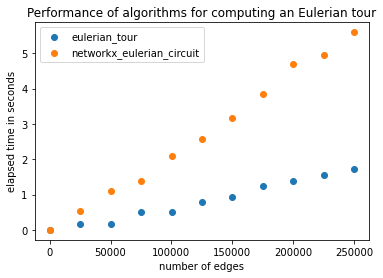

In [232]:
compare_performance(eulerian_tour, 'eulerian_tour')